In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
import lifelines

In [2]:
base = catalog.load("base")

xs = catalog.load("xs")

[11/25/23 18:29:52] INFO     Loading data from 'base' (CSVDataSet)...                           ]8;id=419402;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=409620;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'xs' (CSVDataSet)...                             ]8;id=77125;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=779526;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [3]:
base

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
0,37d76d441d,2020-12-01,NaN,product_a,12.1775,channel_a,55+,iOS
1,cdc1327d79,2022-05-09,NaN,product_a,12.4575,channel_a,18-24,iOS
2,fac8c03aa8,2021-11-20,2023-01-01,product_c,21.6625,channel_a,35-39,Android
3,b0c703a998,2020-05-21,NaN,product_a,12.0475,channel_b,35-39,Android
4,0276bcc756,2021-04-15,NaN,product_c,15.7700,channel_b,35-39,Android
...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12,NaN,product_a,12.6825,channel_a,45-49,iOS
102619,58ce7b5a49,2022-11-27,NaN,product_b,13.6975,channel_a,45-49,iOS
102620,4744036910,2022-07-22,NaN,product_a,12.1925,channel_a,45-49,iOS
102621,ca58e4734d,2021-07-16,NaN,product_a,13.7525,channel_a,50-54,Android


In [4]:
base["operating_system"].value_counts()


operating_system
Android      48405
iOS          47520
iPadOS         797
iPhone OS       18
Name: count, dtype: int64

In [5]:
base.loc[:, "operating_system"] = base["operating_system"].replace({"iPadOS": "iOS", "iPhone OS": "iOS"})

In [6]:
xs

,user_id,product,commission,date
0,ccc05d82e1,product_y,499.6000,2022-08-05
1,77a488f223,product_y,821.2950,2022-10-20
2,e717cb5a0b,product_y,1215.0350,2023-01-19
3,1e9ca78b5b,product_y,413.1800,2022-12-20
4,eee1f85c5c,product_y,354.4475,2022-10-06
...,...,...,...,...
1313,b46d770837,product_y,579.6650,2022-11-01
1314,af3b28aac0,product_y,418.3700,2022-10-11
1315,623b0fe810,product_x,1269.0025,2022-06-30
1316,3cc2642221,product_y,377.0550,2022-09-22


In [7]:
len(base["user_id"].unique()) == len(base)

True

In [8]:
len(xs["user_id"].unique()) == len(xs)

False

In [9]:
xs["user_id"].value_counts().head(1)


user_id
995528dadd    5
Name: count, dtype: int64

In [10]:
base.loc[base["user_id"]=="995528dadd"]

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
22280,995528dadd,2022-04-24,NaN,product_a,12.925,channel_b,30-34,Android


In [11]:
xs.loc[xs["user_id"]=="995528dadd"]

,user_id,product,commission,date
163,995528dadd,product_y,262.00,2022-12-30
164,995528dadd,product_y,1723.60,2022-05-05
165,995528dadd,product_y,195.46,2022-05-05
166,995528dadd,product_y,262.00,2022-12-30
167,995528dadd,product_y,244.60,2023-02-08


In [12]:
def get_commission_per_product(df):
    comission_per_product = df.groupby("product").agg({"commission": ["sum","count"]})
    comission_per_product.columns = list(map('_'.join, comission_per_product.columns.values))
    
    comission_per_product.loc[:,"commission_per_unit"] = comission_per_product["commission_sum"] / comission_per_product["commission_count"]
    return comission_per_product

In [13]:
comission_per_product_base = get_commission_per_product(base)
comission_per_product_xs = get_commission_per_product(xs)
comission_per_product = pd.concat([
        comission_per_product_base,
        comission_per_product_xs
    ],
     ignore_index=False).reset_index()

In [14]:
comission_per_product

,product,commission_sum,commission_count,commission_per_unit
0,product_a,1.014396e+06,82084,12.358022
1,product_b,6.470865e+04,4618,14.012268
2,product_c,3.063894e+05,15921,19.244357
3,product_x,7.797592e+04,79,987.036930
4,product_y,6.511947e+05,976,667.207677


In [ ]:
xs = pd.merge(
    xs,
    pd.get_dummies(xs["product"]),
    left_index=True,
    right_index=True,
)

grouped_xs = xs.groupby("user_id").sum()[["commission", "product_x", "product_y"]].reset_index()

df = pd.merge(
    base,
    grouped_xs,
    on="user_id",
    how="left",
    suffixes=["_base", "_xs"]
)

datetime_cols = ["customer_churned_at", "customer_started_at"]
for col in datetime_cols:
    df.loc[:, col] = pd.to_datetime(df[col], errors="coerce", utc=False)

In [20]:
df.loc[:,"is_churn"] = ~df["customer_churned_at"].isna()

In [21]:
df.groupby("product").agg({"is_churn": "mean"})

,is_churn
product,
product_a,0.363749
product_b,0.295366
product_c,0.460775


In [22]:
df.groupby("channel").agg({"is_churn": "mean"})

,is_churn
channel,
channel_a,0.405983
channel_b,0.350590


In [23]:
df.groupby("operating_system").agg({"is_churn": "mean"})

,is_churn
operating_system,
Android,0.406115
iOS,0.316624


In [24]:
df.groupby("age_bucket").agg({"is_churn": "mean"})

,is_churn
age_bucket,
18-24,0.375311
25-29,0.343820
30-34,0.368132
35-39,0.413617
40-44,0.432981
45-49,0.410924
50-54,0.356282
55+,0.349221
undefined,0.796296


In [25]:
df.groupby("is_xs").agg({"is_churn": "mean"})

,is_churn
is_xs,
0,0.379769
1,0.016623


In [26]:
df

,user_id,customer_started_at,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_xs,is_churn
0,37d76d441d,2020-12-01 00:00:00,NaT,product_a,12.1775,channel_a,55+,iOS,0.0,0.0,0.0,0,False
1,cdc1327d79,2022-05-09 00:00:00,NaT,product_a,12.4575,channel_a,18-24,iOS,0.0,0.0,0.0,0,False
2,fac8c03aa8,2021-11-20 00:00:00,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,0.0,0.0,0.0,0,True
3,b0c703a998,2020-05-21 00:00:00,NaT,product_a,12.0475,channel_b,35-39,Android,0.0,0.0,0.0,0,False
4,0276bcc756,2021-04-15 00:00:00,NaT,product_c,15.7700,channel_b,35-39,Android,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,7df1a34a0d,2021-02-12 00:00:00,NaT,product_a,12.6825,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102619,58ce7b5a49,2022-11-27 00:00:00,NaT,product_b,13.6975,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102620,4744036910,2022-07-22 00:00:00,NaT,product_a,12.1925,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102621,ca58e4734d,2021-07-16 00:00:00,NaT,product_a,13.7525,channel_a,50-54,Android,0.0,0.0,0.0,0,False


In [27]:
df.loc[:, "customer_started_at"] = pd.to_datetime(df["customer_started_at"])

In [28]:
df = df.set_index("customer_started_at")

In [29]:
plot_users = df.groupby(pd.Grouper(freq="M")).agg(
    {
        "user_id" : "count",
        "is_xs": "sum",
    }
)

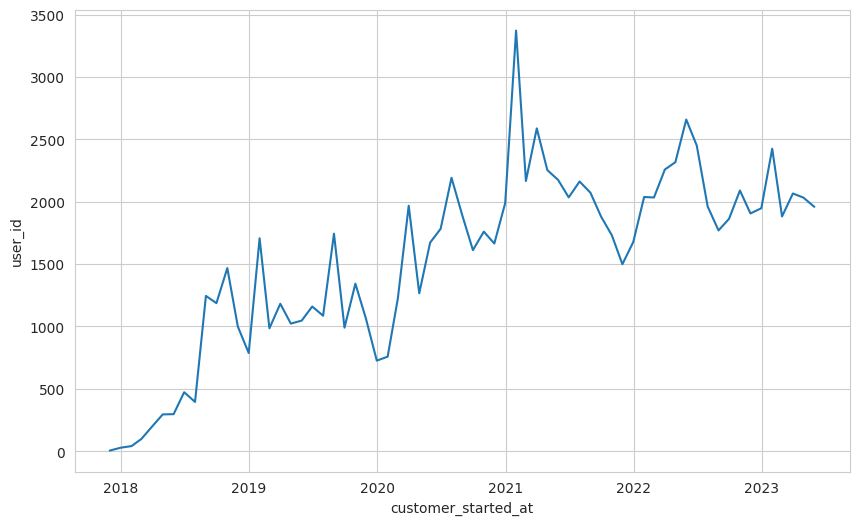

In [30]:
sns.set_style("whitegrid")
fig,axs = plt.subplots(figsize = (10,6))
sns.lineplot(plot_users["user_id"])
plt.show()

In [31]:
plot_users

,user_id,is_xs
customer_started_at,,
2017-11-30,5,0
2017-12-31,28,2
2018-01-31,41,0
2018-02-28,98,1
2018-03-31,199,0
...,...,...
2023-01-31,2425,42
2023-02-28,1882,29
2023-03-31,2066,30


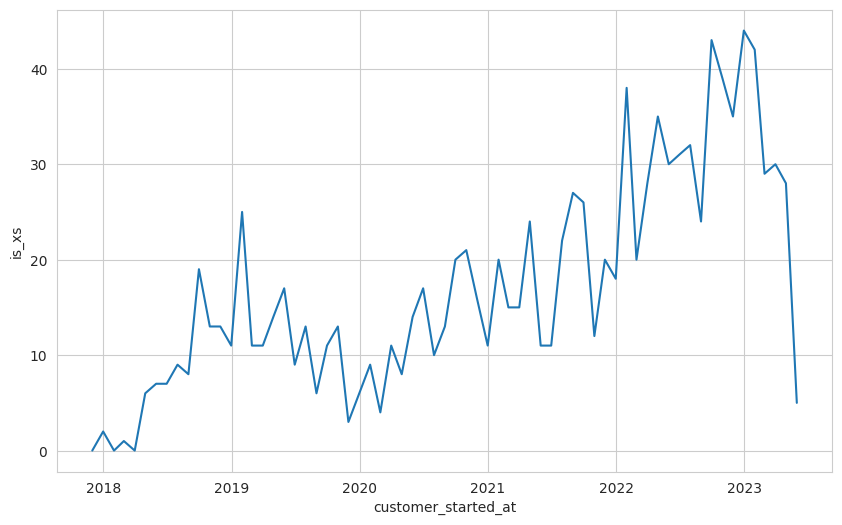

In [32]:
fig,axs = plt.subplots(figsize = (10,6))
sns.lineplot(plot_users["is_xs"])
plt.show()

In [33]:
df = df.reset_index()

In [34]:
df

,customer_started_at,user_id,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_xs,is_churn
0,2020-12-01,37d76d441d,NaT,product_a,12.1775,channel_a,55+,iOS,0.0,0.0,0.0,0,False
1,2022-05-09,cdc1327d79,NaT,product_a,12.4575,channel_a,18-24,iOS,0.0,0.0,0.0,0,False
2,2021-11-20,fac8c03aa8,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,0.0,0.0,0.0,0,True
3,2020-05-21,b0c703a998,NaT,product_a,12.0475,channel_b,35-39,Android,0.0,0.0,0.0,0,False
4,2021-04-15,0276bcc756,NaT,product_c,15.7700,channel_b,35-39,Android,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,2021-02-12,7df1a34a0d,NaT,product_a,12.6825,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102619,2022-11-27,58ce7b5a49,NaT,product_b,13.6975,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102620,2022-07-22,4744036910,NaT,product_a,12.1925,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102621,2021-07-16,ca58e4734d,NaT,product_a,13.7525,channel_a,50-54,Android,0.0,0.0,0.0,0,False


In [35]:
df["customer_started_at"]


0        2020-12-01
1        2022-05-09
2        2021-11-20
3        2020-05-21
4        2021-04-15
            ...    
102618   2021-02-12
102619   2022-11-27
102620   2022-07-22
102621   2021-07-16
102622   2021-09-22
Name: customer_started_at, Length: 102623, dtype: datetime64[ns]

In [36]:
df

,customer_started_at,user_id,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_xs,is_churn
0,2020-12-01,37d76d441d,NaT,product_a,12.1775,channel_a,55+,iOS,0.0,0.0,0.0,0,False
1,2022-05-09,cdc1327d79,NaT,product_a,12.4575,channel_a,18-24,iOS,0.0,0.0,0.0,0,False
2,2021-11-20,fac8c03aa8,2023-01-01 00:00:00,product_c,21.6625,channel_a,35-39,Android,0.0,0.0,0.0,0,True
3,2020-05-21,b0c703a998,NaT,product_a,12.0475,channel_b,35-39,Android,0.0,0.0,0.0,0,False
4,2021-04-15,0276bcc756,NaT,product_c,15.7700,channel_b,35-39,Android,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,2021-02-12,7df1a34a0d,NaT,product_a,12.6825,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102619,2022-11-27,58ce7b5a49,NaT,product_b,13.6975,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102620,2022-07-22,4744036910,NaT,product_a,12.1925,channel_a,45-49,iOS,0.0,0.0,0.0,0,False
102621,2021-07-16,ca58e4734d,NaT,product_a,13.7525,channel_a,50-54,Android,0.0,0.0,0.0,0,False


In [37]:
df.loc[df["is_churn"], "days_to_churn"] = pd.to_datetime(df.loc[df["is_churn"],"customer_churned_at"]).subtract(df.loc[df["is_churn"] ,"customer_started_at"]).dt.days

<Axes: xlabel='days_to_churn', ylabel='Count'>

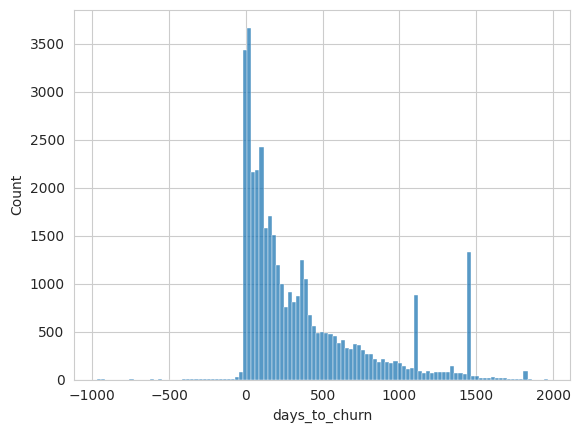

In [38]:
sns.histplot(df.loc[df["is_churn"], "days_to_churn"])

In [39]:
users_churn_negative = df.loc[df.loc[:, "days_to_churn"] <0]["user_id"].to_list()

In [40]:
base.loc[base["user_id"].isin(users_churn_negative)]

,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
24,2be74ed2d0,2020-11-01,2020-10-21,product_c,11.7700,channel_b,30-34,iOS
138,e2a48eefd4,2019-08-19,2019-08-18,product_a,12.5575,channel_a,30-34,Android
188,248b96ed87,2022-02-10,2022-02-09,product_b,17.7700,channel_b,30-34,iOS
235,fd42d75ac6,2020-05-03,2020-05-02,product_a,11.5225,channel_b,40-44,iOS
239,22fa81cbc6,2019-08-09,2019-08-08,product_a,12.5575,channel_a,25-29,Android
...,...,...,...,...,...,...,...,...
102289,e3d3ba4a43,2022-12-24,2022-12-23,product_a,13.4475,channel_b,25-29,iOS
102298,5a957c1a3f,2019-11-17,2019-11-16,product_a,12.5575,channel_a,18-24,iOS
102458,32907bbb05,2021-03-11,2021-03-10,product_c,15.7050,channel_b,35-39,iOS
102528,6d0f098e73,2022-09-29,2022-09-12,product_a,12.4575,channel_a,25-29,iOS


In [41]:
actual_date = max(df["customer_churned_at"].dropna().max(), df["customer_started_at"].dropna().max())
df.loc[df["days_to_churn"]<0, "days_to_churn"] = 0
df.loc[~df["is_churn"], "days_to_churn"] = (actual_date - df.loc[~df["is_churn"], "customer_started_at"]).dt.days

In [42]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = df.loc[:, "days_to_churn"]
E = df.loc[:, "is_churn"]
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 102623 total observations, 64065 right-censored observations>

<Axes: xlabel='timeline'>

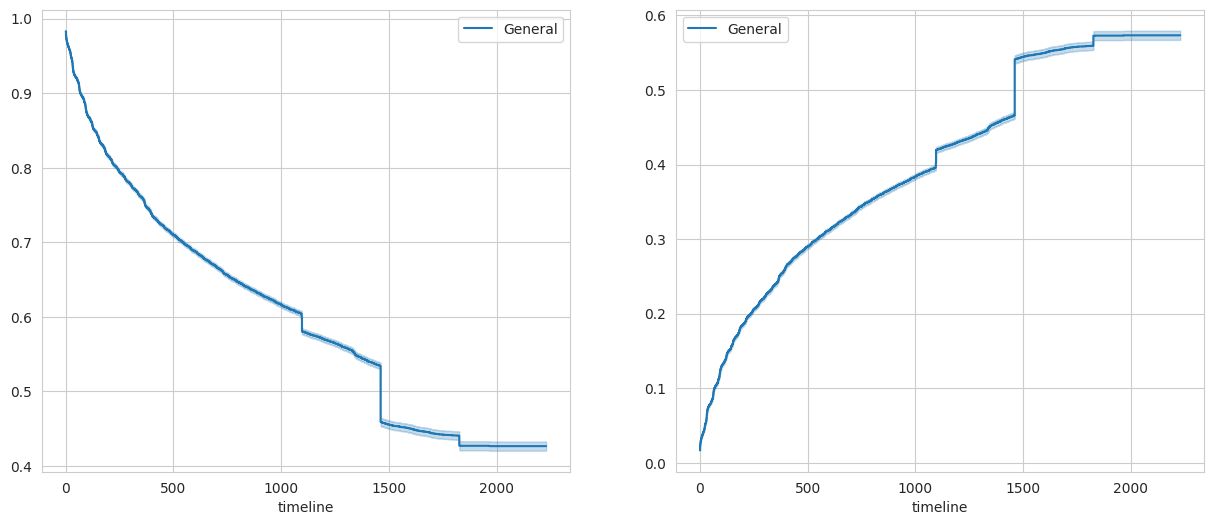

In [43]:
kmf.survival_function_
kmf.cumulative_density_
fig, axs = plt.subplots(1,2, figsize=(15,6))
kmf.plot_survival_function(ax=axs[0], label="General")
kmf.plot_cumulative_density(ax = axs[1], label="General")

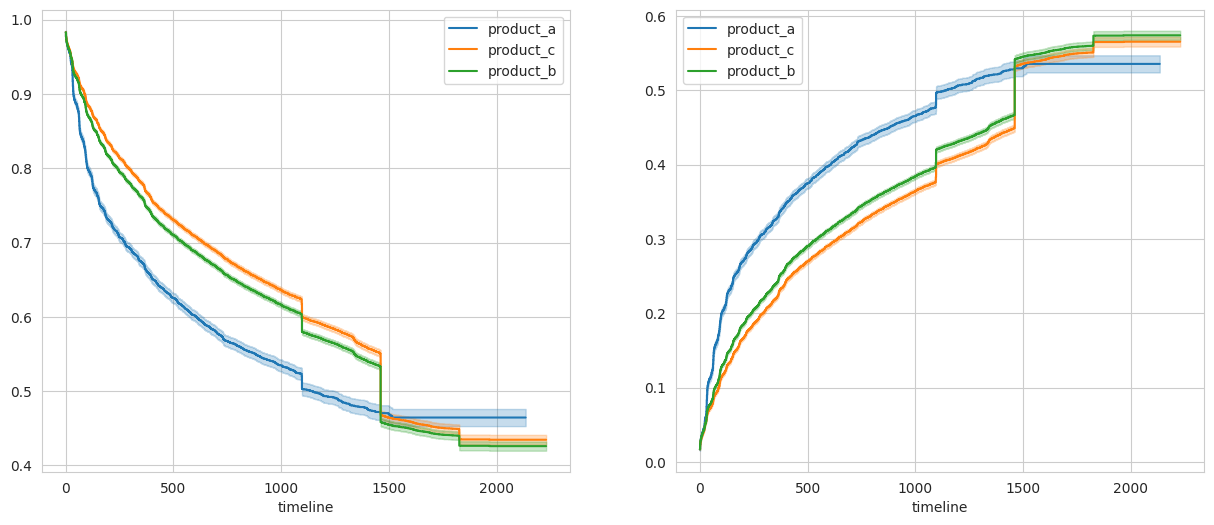

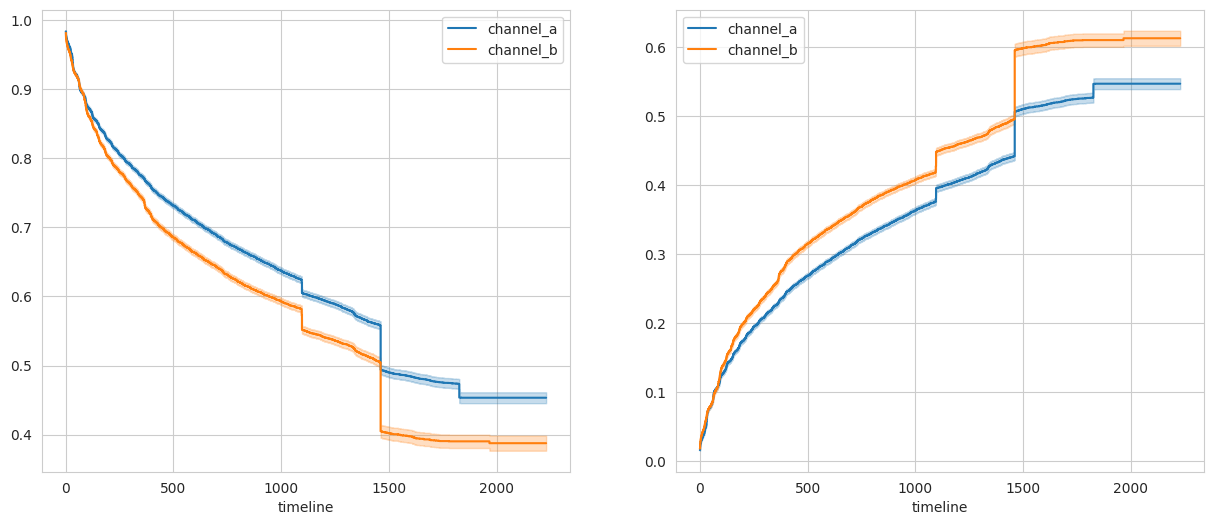

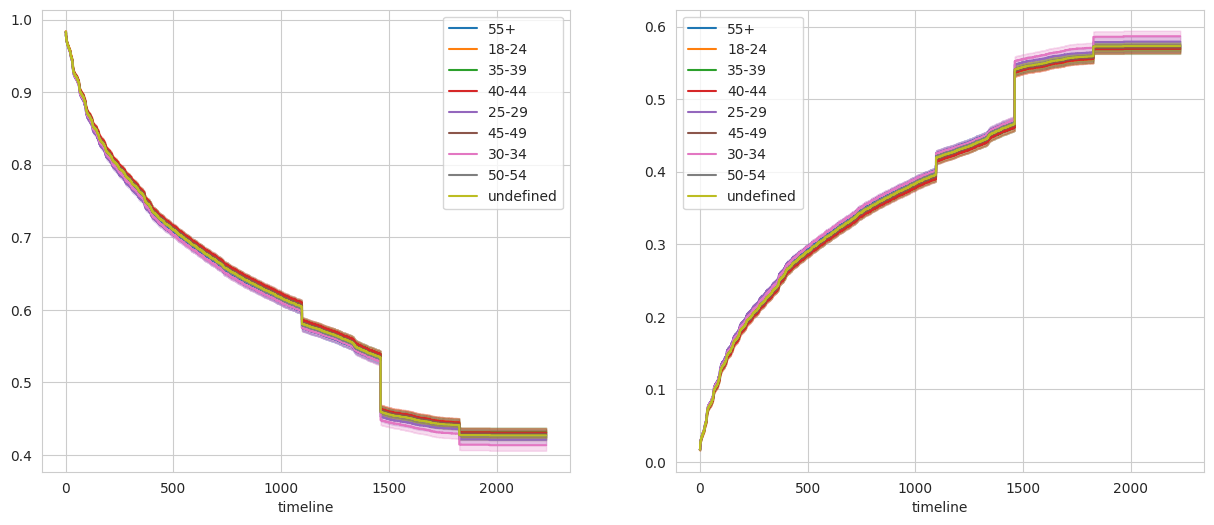

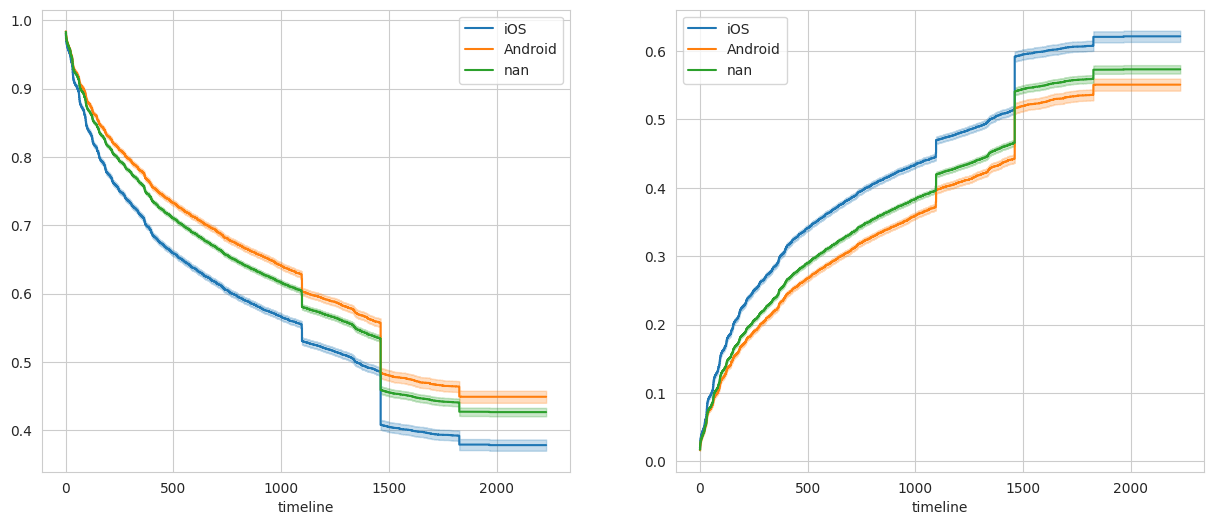

In [44]:
group_cols = ["product", "channel", "age_bucket", "operating_system"]
sns.set_style("whitegrid")
for group_col in group_cols:
    fig, axs = plt.subplots(1,2, figsize=(15,6))
    for group in df[group_col].unique():
        groups = df[group_col]
        ix = (groups == group)
        kmf.fit(T[~ix], E[~ix], label=group)
        kmf.plot_survival_function(ax=axs[0])
        kmf.plot_cumulative_density(ax = axs[1])
    plt.show()

<Axes: xlabel='commission_base', ylabel='Density'>

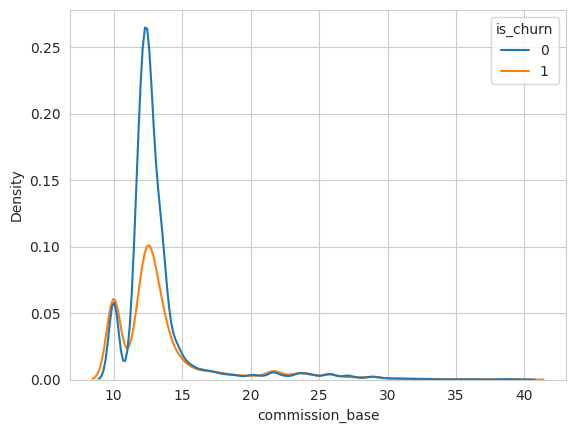

In [45]:
inf_lim, sup_lim = 0,40
col_to_plot = "commission_base"
dataplot = df.loc[(df[col_to_plot]<=sup_lim) & (df[col_to_plot]>=inf_lim)]
sns.kdeplot(data = dataplot, x= col_to_plot, hue=dataplot["is_churn"].astype(int))

In [46]:
num_cols = ["days_to_churn"]
cat_cols = [
    "product",
    "channel",
    "age_bucket",
    "operating_system",
]
ohe_cols = ["product_x", "product_y"]

target = "is_churn"
features = [*cat_cols, *num_cols, *ohe_cols]

X = df[features]
y = df["is_churn"]
data = pd.concat([X, y], axis=1)
data = pd.get_dummies(data, columns= cat_cols, drop_first=False)

In [47]:
cph = lifelines.CoxPHFitter(penalizer=0.0001)
cph.fit(data, duration_col = 'days_to_churn', event_col = 'is_churn')

<lifelines.CoxPHFitter: fitted with 102623 total observations, 64065 right-censored observations>

In [48]:
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

model,lifelines.CoxPHFitter
duration col,'days_to_churn'
event col,'is_churn'
penalizer,0.0001
l1 ratio,0.0
baseline estimation,breslow
number of observations,102623
number of events observed,38558
partial log-likelihood,-422942.638
time fit was run,2023-11-25 17:29:57 UTC
model,base model


In [49]:
# cph.check_assumptions(data, p_value_threshold=0.001, show_plots=True)

In [50]:
avg_score = np.mean(
    lifelines.utils.k_fold_cross_validation(
        cph, data, 'days_to_churn', 'is_churn', k = 5, scoring_method = 'concordance_index'))

In [51]:
print('The average Concordance Score across 10 folds is: {:.3f}'.format(avg_score))

The average Concordance Score across 10 folds is: 0.611


In [52]:
censored_data = data.loc[~data["is_churn"]]
censored_data_last_obs = censored_data["days_to_churn"]

conditioned_sf = cph.predict_survival_function(censored_data, conditional_after = censored_data_last_obs)

In [82]:
cph.predict_survival_function(censored_data.iloc[0])>=0.7

,0
0.0,True
1.0,True
2.0,True
3.0,True
4.0,True
...,...
2204.0,False
2210.0,False
2219.0,False
2222.0,False


In [53]:
conditioned_sf.T.iloc[:,-1]


0         0.799657
1         0.573617
3         0.750358
4         0.532077
5         0.483064
            ...   
102618    0.705586
102619    0.556953
102620    0.618747
102621    0.651119
102622    0.685957
Name: 2229.0, Length: 64065, dtype: float64

In [54]:
conditioned_sf.T.iloc[:,-1].describe()


count    64065.000000
mean         0.673123
std          0.157790
min          0.056034
25%          0.581217
50%          0.661973
75%          0.745914
max          1.000000
Name: 2229.0, dtype: float64

In [55]:
predictions_median = lifelines.utils.median_survival_times(conditioned_sf).T
predictions_median = predictions_median.rename(columns={0.5:"expected_survival"})

data = pd.merge(
    data,
    predictions_median,
    left_index=True,
    right_index=True,
    how="left",
)

data.loc[:,"expected_survival"] = data.loc[:,"expected_survival"].replace({np.inf: np.NaN, -np.inf:np.NaN})

df = pd.merge(
    df,
    data[["expected_survival"]],
    left_index=True,
    right_index=True,
    how="left"
)

In [56]:
df.sort_values(by="expected_survival")

,customer_started_at,user_id,customer_churned_at,product,commission_base,channel,age_bucket,operating_system,commission_xs,product_x,product_y,is_xs,is_churn,days_to_churn,expected_survival
57179,2020-04-01,52b74d2dcc,NaT,product_c,10.9100,channel_b,18-24,NaN,0.0,0.0,0.0,0,False,1370.0,91.0
93920,2020-06-16,309ea33d97,NaT,product_c,17.8100,channel_a,50-54,NaN,0.0,0.0,0.0,0,False,1294.0,167.0
10432,2020-07-20,a095135233,NaT,product_a,12.1750,channel_a,18-24,NaN,0.0,0.0,0.0,0,False,1260.0,202.0
18414,2020-07-29,32caf707ee,NaT,product_c,15.2700,channel_a,40-44,NaN,0.0,0.0,0.0,0,False,1251.0,210.0
71361,2020-07-31,750957b9db,NaT,product_c,16.7325,channel_b,18-24,NaN,0.0,0.0,0.0,0,False,1249.0,212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102618,2021-02-12,7df1a34a0d,NaT,product_a,12.6825,channel_a,45-49,iOS,0.0,0.0,0.0,0,False,1053.0,NaN
102619,2022-11-27,58ce7b5a49,NaT,product_b,13.6975,channel_a,45-49,iOS,0.0,0.0,0.0,0,False,400.0,NaN
102620,2022-07-22,4744036910,NaT,product_a,12.1925,channel_a,45-49,iOS,0.0,0.0,0.0,0,False,528.0,NaN
102621,2021-07-16,ca58e4734d,NaT,product_a,13.7525,channel_a,50-54,Android,0.0,0.0,0.0,0,False,899.0,NaN


<Axes: xlabel='days_to_churn', ylabel='Count'>

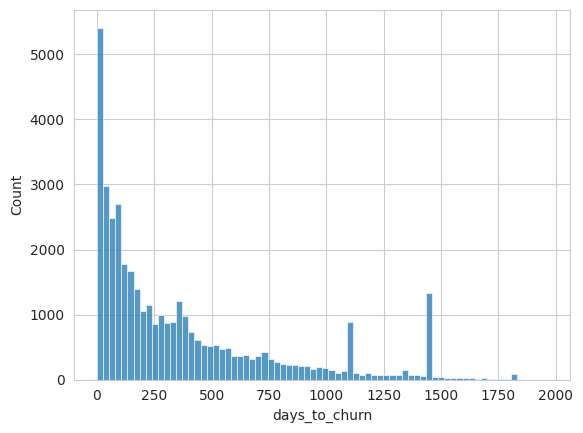

In [57]:
sns.histplot(df.loc[df["is_churn"], "days_to_churn"])

<Axes: xlabel='expected_survival', ylabel='Count'>

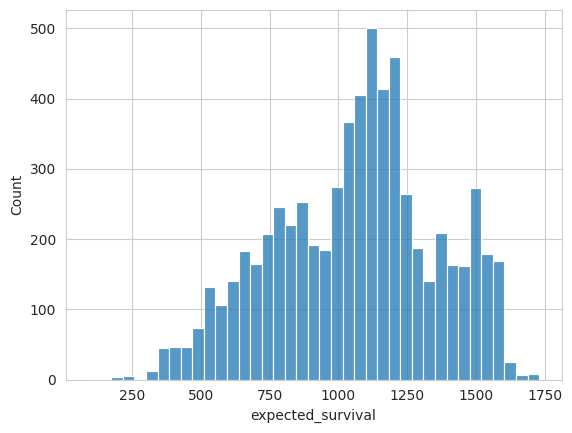

In [58]:
sns.histplot(df["expected_survival"])

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

CT = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("numerical", StandardScaler(), num_cols)
])

In [60]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_ROC(_pipe, X_test, y_test):
    probs = _pipe.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    # method I: plt
    plt.title(f'Receiver Operating Characteristic: {type(pipe["model"]).__name__}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [61]:
models = [
    RandomForestClassifier(),
    XGBClassifier(n_estimators=1000),
    GradientBoostingClassifier()
]
for model in models:
    pipe = Pipeline([
        ("CT", CT),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    plot_ROC(pipe, X_test, y_test)
    plot_confusion_matrix(pipe, X_test, y_test)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 models = [                                                                                  │
│    2 │   RandomForestClassifier(),                                                               │
│ ❱  3 │   XGBClassifier(n_estimators=1000),                                                       │
│    4 │   GradientBoostingClassifier()                                                            │
│    5 ]                                                                                           │
│    6 for model in models:                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'XGBClassifier' is not defined

In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(_pipe, _X, y_true):
    # Predict labels using the provided model
    y_pred = _pipe.predict(_X)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plotting the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
xgb = XGBClassifier()
parameters = {
    "n_estimators": [400, 500, 600],
    "max_depth": [4, 5, 6]
}
clf = GridSearchCV(xgb, parameters, n_jobs=-1, verbose=3)
pipe = Pipeline([
    ("CT", CT),
    ("model", clf)
])
pipe.fit(X_train, y_train)
plot_ROC(pipe, X_test, y_test)
plot_confusion_matrix(pipe, X_test, y_test)

In [ ]:
pipe["model"].best_params_